# 12.4c: Qwen Population Histogram

**Goal:** Visualize the distribution of black hole sizes in Qwen's snowball.

This is the histogram Jeffery is asking about: how many tokens are in each unique vector position.

Expected:
- 111 bins with count=1 (singletons)
- 13 bins with count≥2 (black holes), including two huge ones at ~800 and ~700

## Parameters

In [1]:
# Input paths
GAMMA_CENTERED_PATH = "../data/tensors/gamma_centered_qwen3_4b_instruct_2507.safetensors"
MASK_PATH = "../data/tensors/black_hole_mask.safetensors"

# Figure settings
DPI = 150
COLORMAP = 'inferno'

RANDOM_SEED = 42

## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("✓ Imports complete")

✓ Imports complete


## Load Data

In [3]:
print("Loading data...\n")

# Load centered gamma
gamma_data = load_file(GAMMA_CENTERED_PATH)
gamma_centered = gamma_data['gamma_centered'].to(torch.float32)
print(f"✓ Loaded γ_centered")
print(f"  Shape: {gamma_centered.shape}")

# Load black hole mask
mask_data = load_file(MASK_PATH)
mask = mask_data['mask']
print(f"\n✓ Loaded black hole mask")
print(f"  Dead tokens: {mask.sum().item():,}")

# Extract dead token embeddings
dead_tokens = gamma_centered[mask]
print(f"\n✓ Extracted dead token embeddings")
print(f"  Shape: {dead_tokens.shape}")

Loading data...

✓ Loaded γ_centered
  Shape: torch.Size([151936, 2560])

✓ Loaded black hole mask
  Dead tokens: 2,100

✓ Extracted dead token embeddings
  Shape: torch.Size([2100, 2560])


## Find Unique Vectors and Counts

In [4]:
print("\nFinding unique vectors...\n")

unique_vectors, inverse_indices, counts = torch.unique(
    dead_tokens,
    dim=0,
    return_inverse=True,
    return_counts=True
)

print(f"✓ Found {len(unique_vectors)} unique vectors")
print(f"\nCounts distribution:")
print(f"  Min count: {counts.min().item()}")
print(f"  Max count: {counts.max().item()}")
print(f"  Mean count: {counts.float().mean().item():.2f}")
print(f"  Median count: {counts.float().median().item():.0f}")

# Identify singletons and black holes
singleton_mask = counts == 1
black_hole_mask = counts >= 2

n_singletons = singleton_mask.sum().item()
n_black_holes = black_hole_mask.sum().item()

print(f"\nBreakdown:")
print(f"  Singletons (count=1): {n_singletons}")
print(f"  Black holes (count≥2): {n_black_holes}")

# Show top 10 black holes
bh_counts = counts[black_hole_mask]
sorted_bh_counts = torch.sort(bh_counts, descending=True)[0]

print(f"\nTop 10 black hole sizes:")
for i, count in enumerate(sorted_bh_counts[:10], 1):
    print(f"  #{i}: {count.item()} tokens")


Finding unique vectors...

✓ Found 13 unique vectors

Counts distribution:
  Min count: 2
  Max count: 814
  Mean count: 161.54
  Median count: 6

Breakdown:
  Singletons (count=1): 0
  Black holes (count≥2): 13

Top 10 black hole sizes:
  #1: 814 tokens
  #2: 704 tokens
  #3: 306 tokens
  #4: 228 tokens
  #5: 11 tokens
  #6: 10 tokens
  #7: 6 tokens
  #8: 5 tokens
  #9: 4 tokens
  #10: 4 tokens


## Figure: Population Distribution Histogram

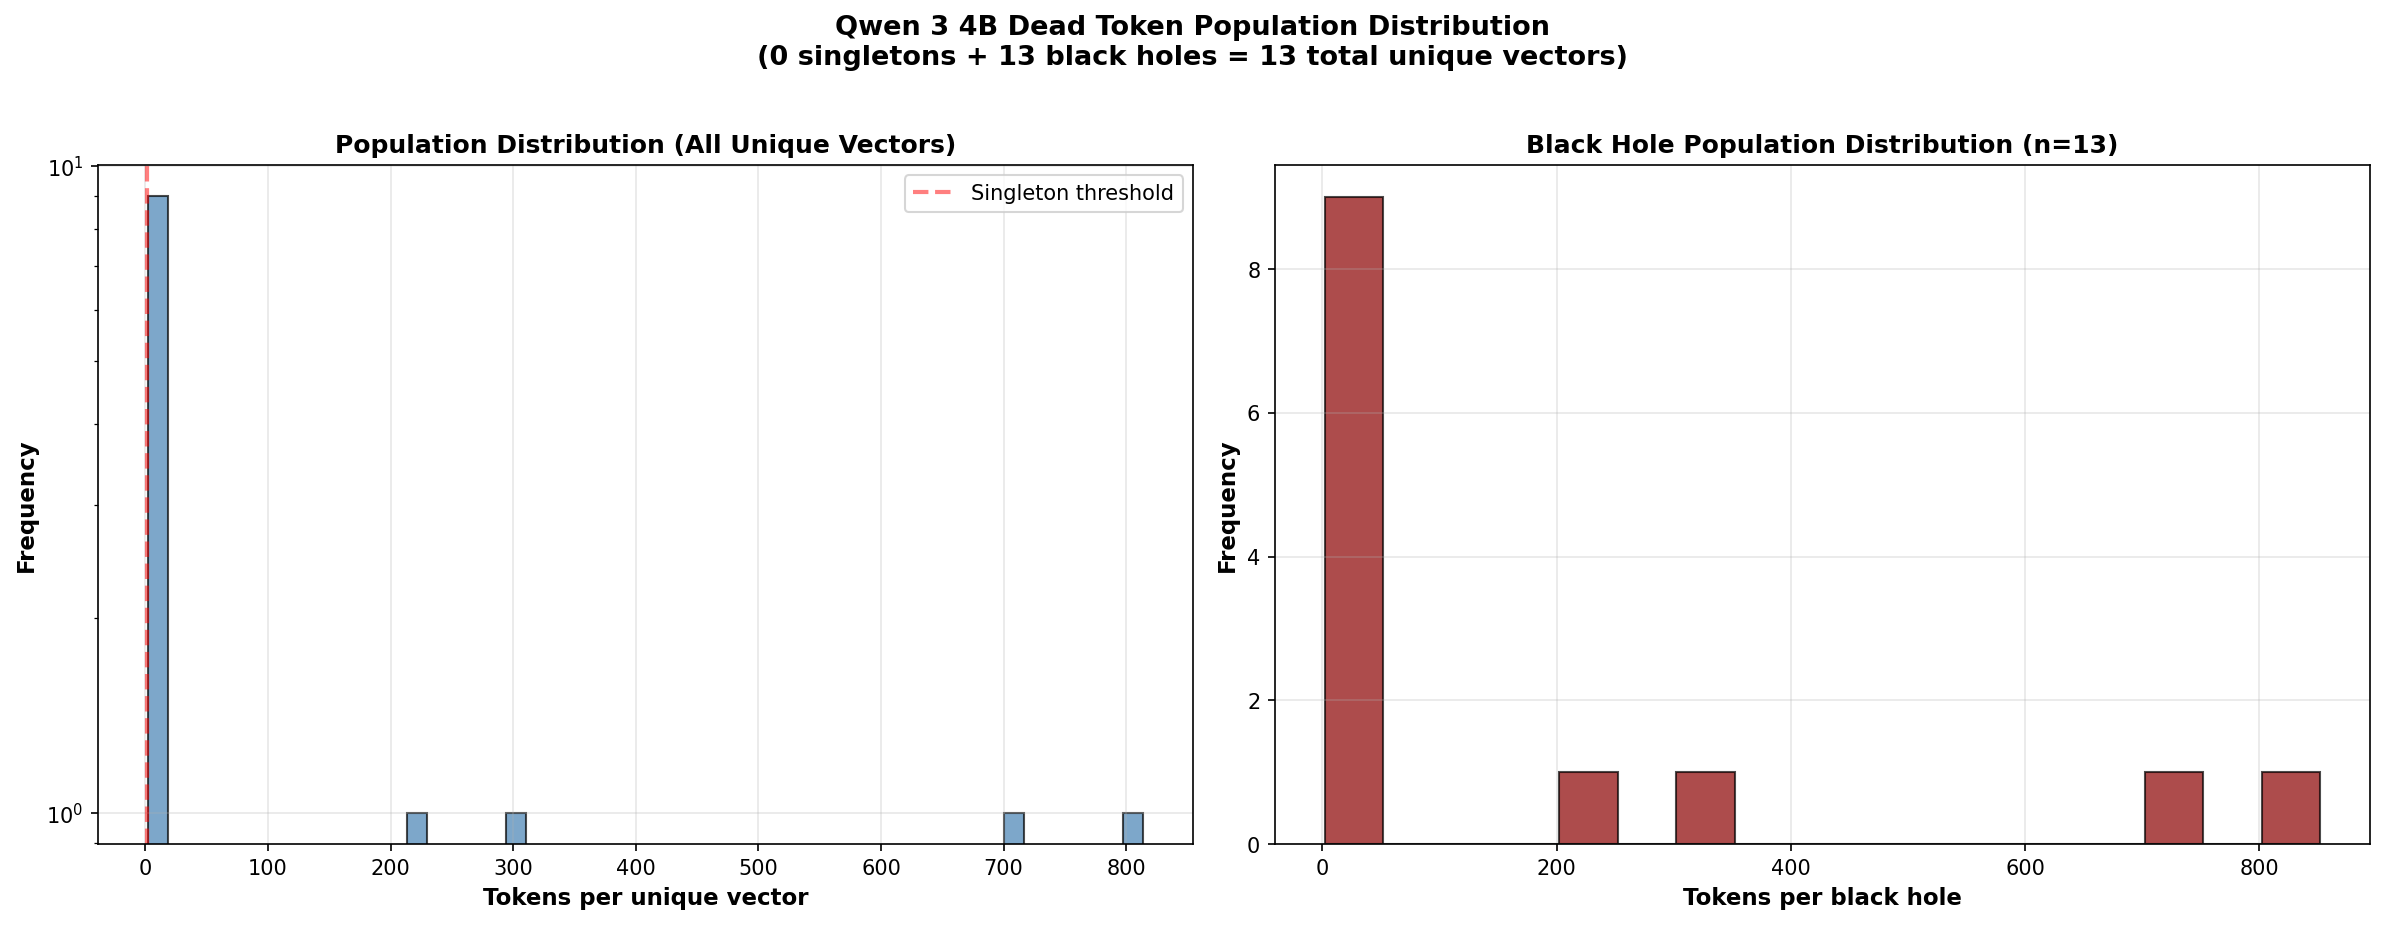

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), dpi=DPI)

# Left panel: Full distribution (log scale)
ax = axes[0]
ax.hist(counts.cpu().numpy(), bins=50, color='steelblue', alpha=0.7, edgecolor='black')
ax.axvline(1, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Singleton threshold')
ax.set_xlabel('Tokens per unique vector', fontsize=11, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax.set_title('Population Distribution (All Unique Vectors)', fontsize=12, fontweight='bold')
ax.set_yscale('log')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Right panel: Black holes only (linear scale)
ax = axes[1]
bh_counts_np = bh_counts.cpu().numpy()
ax.hist(bh_counts_np, bins=np.arange(2, bh_counts_np.max() + 50, 50), 
        color='darkred', alpha=0.7, edgecolor='black')
ax.set_xlabel('Tokens per black hole', fontsize=11, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax.set_title(f'Black Hole Population Distribution (n={n_black_holes})', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.suptitle(f"Qwen 3 4B Dead Token Population Distribution\n({n_singletons} singletons + {n_black_holes} black holes = {len(counts)} total unique vectors)",
             fontsize=13, fontweight='bold', y=1.02)

plt.tight_layout()
plt.show()

## Summary

In [6]:
print(f"\n{'='*60}")
print(f"QWEN POPULATION DISTRIBUTION")
print(f"{'='*60}")
print(f"\nTotal dead tokens: {len(dead_tokens):,}")
print(f"Unique vectors: {len(unique_vectors):,}")
print(f"\nSingletons: {n_singletons} ({n_singletons/len(unique_vectors)*100:.1f}%)")
print(f"Black holes: {n_black_holes} ({n_black_holes/len(unique_vectors)*100:.1f}%)")
print(f"\nTop 2 black holes contain: {sorted_bh_counts[:2].sum().item()} / {len(dead_tokens)} tokens ({sorted_bh_counts[:2].sum().item()/len(dead_tokens)*100:.1f}%)")
print(f"\n{'='*60}")


QWEN POPULATION DISTRIBUTION

Total dead tokens: 2,100
Unique vectors: 13

Singletons: 0 (0.0%)
Black holes: 13 (100.0%)

Top 2 black holes contain: 1518 / 2100 tokens (72.3%)

